# 3.2 비트코인 시세 예측하기

- __시계열 데이터__ : 비트코인 시세처럼 연속적인 시간에 따라 다르게 측정되는 데이터  
    - 규칙적 시계열 데이터 분석 : 심장 박동 데이터 분석  
    - 불규칙적 시계열 분석 : 비트코인 시세 예측

## 1) 탐색 : 시간 정보가 포함된 데이터 살펴보기

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Source : https://www.blockchain.com/ko/charts/market-price?timespan=60days
file_path = 'data/market-price.csv' # 최신 데이터
bitcoin_df = pd.read_csv(file_path, names=['day','price'])
bitcoin_df.drop(bitcoin_df.index[0], inplace=True)
bitcoin_df['price'] = bitcoin_df['price'].astype(float)
bitcoin_test_df = bitcoin_df[-5:] # test data
bitcoin_df = bitcoin_df[:-5] # train data

# 기본 정보 출력
print(bitcoin_df.shape)
bitcoin_df.info()

(361, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 1 to 361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     361 non-null    object 
 1   price   361 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.5+ KB


In [2]:
bitcoin_df.head()

,day,price
1,2020-01-23 00:00:00,8658.94
2,2020-01-24 00:00:00,8388.11
3,2020-01-25 00:00:00,8428.17
4,2020-01-26 00:00:00,8327.36
5,2020-01-27 00:00:00,8588.42


In [3]:
bitcoin_df.tail()

,day,price
357,2021-01-13 00:00:00,34011.82
358,2021-01-14 00:00:00,37393.13
359,2021-01-15 00:00:00,39158.47
360,2021-01-16 00:00:00,36828.52
361,2021-01-17 00:00:00,36065.20


In [4]:
# to_datetime으로 day를 시계열 feature로 변환
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day를 데이터 프레임의 index로 설정
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)
bitcoin_df.head()

,price
day,
2020-01-23,8658.94
2020-01-24,8388.11
2020-01-25,8428.17
2020-01-26,8327.36
2020-01-27,8588.42


In [5]:
bitcoin_df.describe()

,price
count,361.000000
mean,12391.123158
std,6672.638855
min,4830.210000
25%,9154.190000
50%,10121.520000
75%,11925.460000
max,40670.250000


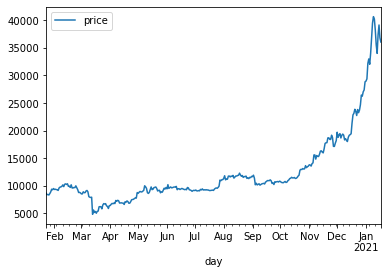

In [6]:
# 일자별 비트코인 시세 시각화
bitcoin_df.plot()
plt.show()

## 2) 예측 : 파이썬 라이브러리를 활용해 시세 예측

- ARIMA 분석 방법 : 전통적인 시계열 예측 방법으로 크게 두 가지 개념을 포함하고 있다.  
1. AR 모델 (Autoregression, 자기회귀, 과거의 관측치)  
: 자기 자신의 과거를 정보로 사용하는 개념  
: '현재의 상태는 이전의 상태를 참고해서 계산된다'라는 아이디어 전제  
: 미래값을 과거값의 선형 회귀로 예측하는 것

2. MA 모델 (Moving Average, 이동평균, 과거의 error)  
: '이전 항에서의 오차를 이용하여 현재 항의 상태를 추론하겠다'라는 방법  
: 미래값을 과거의 예측 오류를 사용해서 예측하는 것

- __ARMA 모델__ = AR 모델 + MA 모델  
    => 현실에 존재하는 시계열 자료는 불안정(non-stationary)한 경우가 많다.  
    => 그런데 AR(p), MA(q) 모형이나, 이 둘을 합한 ARMA(p, q)모형으로는 이러한 불안정성을 설명할 수가 없다.  
    => 따라서 모형 그 자체에 이러한 비정상성을 제거하는 과정을 포함한 것이 ARIMA 모형이며, ARIMA(p, d, q)로 표현한다.


- __ARIMA 모델__ (Autoregressive Integrated Moving Average) : ARMA 모델에 추세 변동의 _경향성(momentum)_ 까지 반영한 방법  
    => I (Integrated) : 누적을 의미, 몇 번의 differencing을 수행할 것인가?  
    => 파이썬에서는 statsmodel 모듈로 ARIMA 분석 수행할 수 있음  
    
    
(참고)  
https://byeongkijeong.github.io/ARIMA-with-Python/  
https://m.blog.naver.com/PostView.nhn?blogId=nywoo19&logNo=221600142327&proxyReferer=https:%2F%2Fwww.google.com%2F

_* ARIMA 클래스에 <span style="color:blue">order=(p,d,q)</span> 파라미터의 의미 *_  
(1) <span style="color:blue">p</span> : AR이 몇 번째 과거까지를 바라보는지에 대한 파라미터  - 계절성  
(2) <span style="color:blue">q</span> : 차분(difference)에 대한 파라미터 - 추세  
(3) <span style="color:blue">d</span> : MA가 몇 번째의 과거까지를 바라보는지에 대한 파라미터 - 노이즈  

- 예제의 분석 결과와는 별개로 order 파라미터 p, d, q는 일반적인 가이드라인이 존재.  
        => 보통은 'p + q < 2 인 경우' or 'p * q = 0을 포함한 짝수인 경우'가 좋은 파라미터의 조합이라고 알려져 있다.  
        => p, d 둘 중 하나의 모수가 0이라는 것은 실제로 대부분의 시계열 자료에서는 하나의 경향만을 강하게 띄기 때문에, 하나의 모수를 0으로 설정한다.

- 차분(difference)?  
: 현재 상태의 변수에서 바로 전 상태의 변수를 빼주는 것을 의미  
: 시계열 데이터의 _불규칙성을 조금이나마 보정_ 해주는 역할  
: 또한, 앞서 말한 ARIMA 모델의 _'경향성'_ 을 의미

### (1) _ARIMA 모델 학습_

In [7]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델 학습
model = ARIMA(bitcoin_df.price.values, order=(0,1,1))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  360
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2803.268
Method:                       css-mle   S.D. of innovations            582.806
Date:                Fri, 22 Jan 2021   AIC                           5612.536
Time:                        20:46:07   BIC                           5624.194
Sample:                             1   HQIC                          5617.172
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.7024     37.181      2.036      0.042       2.829     148.576
ma.L1.D.y      0.2110      0.054      3.923      0.000       0.106       0.316
                                    Roots           

- 모든 계수의 p-value가 0.05 이하로 유의미한 것을 나타낸다.

### _학습 결과_

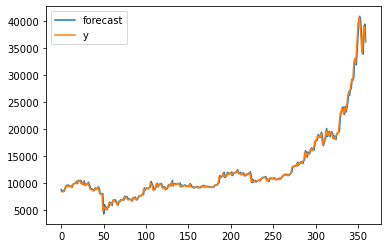

In [8]:
# 학습 데이터에 대한 예측 결과
fig = model_fit.plot_predict() # 시각화 자동으로 해주는 함수

<AxesSubplot:>

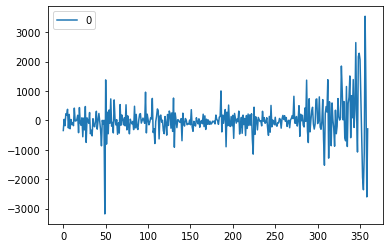

In [9]:
# 실제값과 예측값 사이의 오차 변동을 나타내는 그래프
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

- 이 그래프의 폭이 일정하다면 좋은 예측 모델을 학습시킨 것이라고 생각할 수 있다. 
- 하지만 현재 실행 결과, 오차 변동이 매우 불안정한 것으로 보인다.

### _ARIMA 모델 평가_

- train data의 마지막 datetime 기준 __이후 5일 동안__의 데이터 불러와서 예측값과 비교
- 불규칙적 시계열 예측의 경우 먼 미래를 예측하는 것이 큰 의미가 없으므로 __'앞으로 N일 동안 어느정도로 상승/하락할 것이다'__ 정도의 대략적인 경향 예측만을 수행하는 것이 일반적이기 때문

In [10]:
# train data로부터 5일 뒤 예측
forecast_data = model_fit.forecast(steps=5)
forecast_data

(array([36079.83860068, 36155.54101332, 36231.24342596, 36306.9458386 ,
        36382.64825124]),
 array([ 582.80570152,  915.32608043, 1155.84652151, 1354.30444475,
        1527.18691615]),
 array([[34937.56041572, 37222.11678564],
        [34361.53486158, 37949.54716507],
        [33965.82587214, 38496.66097978],
        [33652.55790278, 38961.33377442],
        [33389.41689792, 39375.87960456]]))

In [11]:
# test data
bitcoin_test_df.reset_index(drop=True, inplace=True)
bitcoin_test_df.rename(columns={'day': 'ds', 'price' : 'y'}, inplace=True)
bitcoin_test_df

,ds,y
0,2021-01-18 00:00:00,35793.01
1,2021-01-19 00:00:00,36632.35
2,2021-01-20 00:00:00,36020.13
3,2021-01-21 00:00:00,35538.98
4,2021-01-22 00:00:00,30797.88


In [12]:
# 마지막 5일의 예측 데이터
pred_y = forecast_data[0].tolist()
pred_y

[36079.838600681716,
 36155.5410133215,
 36231.24342596128,
 36306.94583860106,
 36382.64825124084]

In [13]:
# 실제 5일 가격 데이터
test_y = bitcoin_test_df.y.values
test_y

array([35793.01, 36632.35, 36020.13, 35538.98, 30797.88])

In [14]:
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

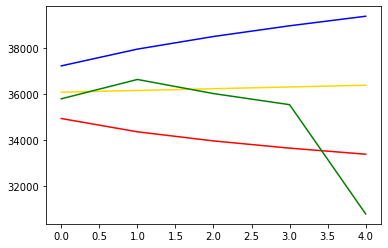

In [15]:
plt.plot(pred_y, color='gold') # 모델 예측값
plt.plot(pred_y_lower, color='red') # 모델 예측 하한가
plt.plot(pred_y_upper, color='blue') # 모델 예측 상한가
plt.plot(test_y, color='green') # 실제값

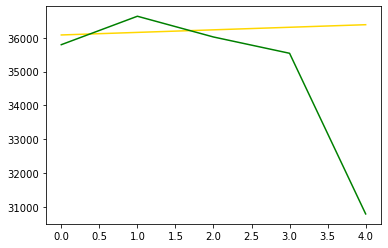

In [16]:
plt.plot(pred_y, color='gold') # 모델 예측값
plt.plot(test_y, color='green') # 실제값

-> 모델은 '5일 동안 상승할 것이다'라는 예측을 했지만, 실제로는 증가 추세를 보이다가 급하락했음.

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# test RMSE 점수
rmse = sqrt(mean_squared_error(pred_y, test_y))
rmse

2535.097405777277

### (2) _Prophet 모델_

- Facebook Prophet : ARIMA 보다 조금 더 정확한 트렌드 예측 분석을 제공하는 라이브러리
- Prophet  
: Additive 모델이라는 모델링 방법에 기반한 시계열 예측 모델  
: 시계열 데이터의 트렌드성 (연간/월간/일간)을 예측하는 것에 초점  

> fbprophet 라이브러리의 사용을 위해서는 데이터 프레임의 feature를 'ds'와 'y'로 변경해야함.  

> 모델 생성에 포함되는 파라미터  
seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미하는 파라미터  
changepoint_prior_scale : 트렌드가 변경되는 문맥을 반영하는 파라미터. 수치가 높을수록 모델은 과적합에 가까워짐

- Additive 모델  
: 선형 회귀 분석의 단점을 극복하기 위해 개량된 분석 방법의 하나(시계열 분석 역시 회귀 분석의 한 갈래이기 때문에 회귀 분석의 단점을 가지고 있음)  
: 하지만 회귀 분석의 단점을 극복하기 위해 이 모델은 각 feature마다 _비선형적 적합_ 을 가능하게 하는 일련의 방법을 적용한다.

In [18]:
from fbprophet import Prophet

# prophet을 사용하기 위해서는 다음과 같이 feature의 이름을 변경해야 함.
bitcoin_df = pd.read_csv(file_path, names=['ds','y'])
bitcoin_df.drop(bitcoin_df.index[0], inplace=True)
bitcoin_df['y'] = bitcoin_df['y'].astype(float)
bitcoin_df = bitcoin_df[:-5] # train data

In [19]:
bitcoin_df.tail()

,ds,y
357,2021-01-13 00:00:00,34011.82
358,2021-01-14 00:00:00,37393.13
359,2021-01-15 00:00:00,39158.47
360,2021-01-16 00:00:00,36828.52
361,2021-01-17 00:00:00,36065.20


In [20]:
# Facebook Prophet을 활용하여 시계열 모델 학습
prophet = Prophet(seasonality_mode='multiplicative',
                 yearly_seasonality=True,
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

In [21]:
# 5일을 내다보며 예측
# train dataset 기반의 5일 단위 예측 데이터를 얻을 수 있다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-01-23,1141.131124,7574.652294,9085.973150,1141.131124,1141.131124,5.836536,5.836536,5.836536,6.329923,...,0.039043,0.039043,0.039043,0.454344,0.454344,0.454344,0.0,0.0,0.0,8364.403749
1,2020-01-24,1199.875097,7780.288271,9367.110142,1199.875097,1199.875097,5.836536,5.836536,5.836536,6.150526,...,0.093143,0.093143,0.093143,0.220848,0.220848,0.220848,0.0,0.0,0.0,8579.738659
2,2020-01-25,1258.619069,7884.464856,9449.129853,1258.619069,1258.619069,5.836536,5.836536,5.836536,5.859787,...,0.033107,0.033107,0.033107,-0.009856,-0.009856,-0.009856,0.0,0.0,0.0,8633.858776
3,2020-01-26,1317.363042,7949.084474,9577.476855,1317.363042,1317.363042,5.836536,5.836536,5.836536,5.670788,...,0.067911,0.067911,0.067911,-0.233659,-0.233659,-0.233659,0.0,0.0,0.0,8787.849922
4,2020-01-27,1376.107014,7963.476936,9604.495975,1376.107014,1376.107014,5.836536,5.836536,5.836536,5.371368,...,-0.018567,-0.018567,-0.018567,-0.446600,-0.446600,-0.446600,0.0,0.0,0.0,8767.684752


In [22]:
forecast_data[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
361,2021-01-18,36236.939944,35412.494718,36968.793466
362,2021-01-19,35290.540541,34376.602889,36088.977279
363,2021-01-20,34538.747210,33739.377623,35318.082433
364,2021-01-21,34506.546174,33669.110097,35329.436890
365,2021-01-22,33977.694041,33075.070806,34904.338918


### _시각화_
- 전체 데이터 기반으로 학습한, 5일 단위의 예측 결과 시각화

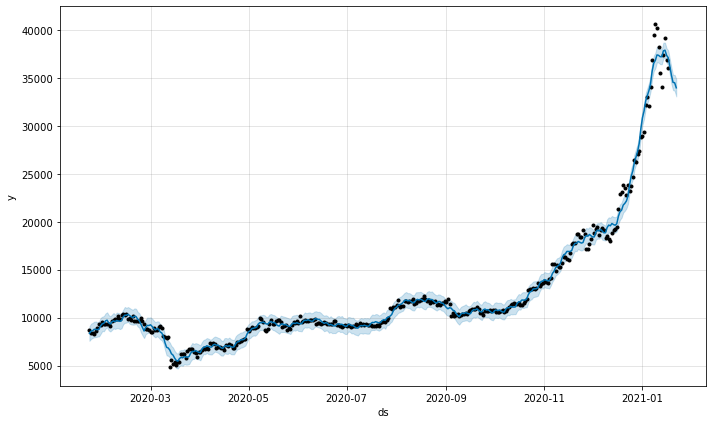

In [23]:
fig1 = prophet.plot(forecast_data)

- 그래프의 검은 점 : 실제 가격
- 그래프의 파란 선 : 예측 가격
- ARIMA 모델과 마찬가지로 학습 데이터셋에 대해서는 거의 정확한 예측을 하지만 시계열 데이터 분석에서 학습 데이터를 잘 예측하는 것은 큰 의미 x

#### _트렌드 정보 시각화_
- 앞서 seasonality_mode 파라미터를 설정해놓은 경우에만 시각화 가능
- 이를 통해 시계열 데이터가 어떤 흐름을 가지고 변화하는지 살펴볼 수 있다.
- 첫 번째 그래프 : 전체적인 데이터의 트렌드 확인
- 이어지는 그래프 : year, weekly, daily 순의 트렌드 확인

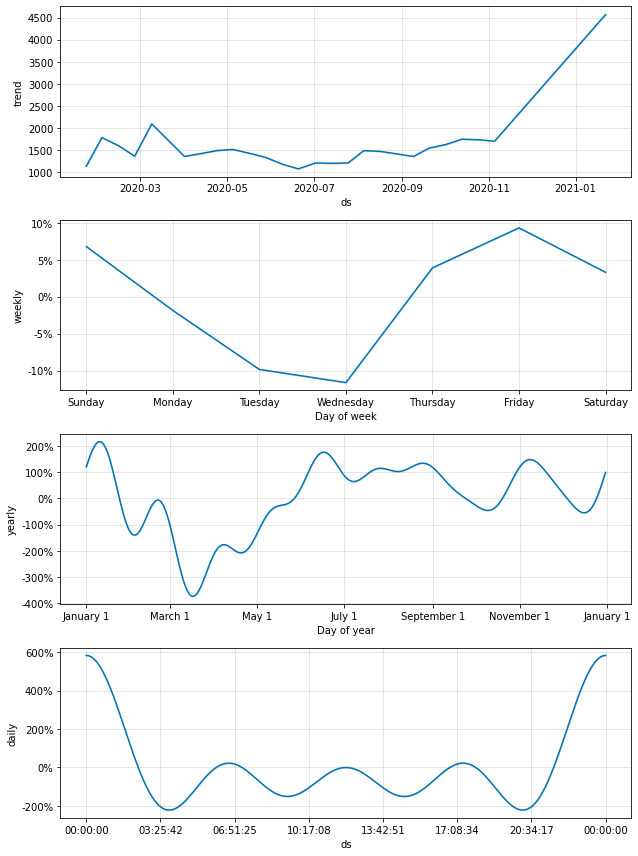

In [24]:
fig2 = prophet.plot_components(forecast_data)

### _Prophet 모델 평가_

- 실제 가격과 예측한 가격 간의 차이 : 첫 5일과 마지막 5일은 제외하고 계산
- train RMSE 점수 : 619.16
- train r2 점수 (train 데이터에 대한 모델의 설명력) : 0.99

In [25]:
y = bitcoin_df.y.values[5:] # 첫 5일을 제외한 실제 가격 데이터
y_pred = forecast_data.yhat.values[5:-5] # 첫 5일, 마지막 5일을 제외한 예측 가격 데이터

In [26]:
rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

619.1637455072996
0.9914439383148649


#### _실제 데이터와의 비교_

In [27]:
pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측
test_y = bitcoin_test_df.y.values # 실제 5일 가격
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 하한가 예측
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 상한가 예측

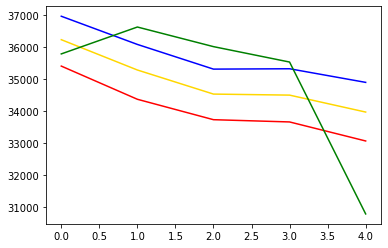

In [28]:
plt.plot(pred_y, color='gold') # 모델 예측값
plt.plot(pred_y_lower, color='red') # 모델 예측 하한가
plt.plot(pred_y_upper, color='blue') # 모델 예측 상한가
plt.plot(test_y, color='green') # 실제값

1753.2346295339798


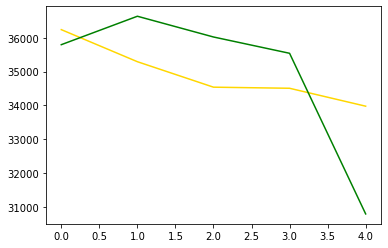

In [29]:
plt.plot(pred_y, color='gold') # 모델 예측값
plt.plot(test_y, color='green') # 실제값
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

- ARIMA 모델의 test RMSE인 2535와 비교해보면 크게 감소했다.
- 하지만 모델이 예측한 상한가(blue)보다 실제 가격(green)이 더 높기 때문에 모델의 예측 별로다:(
- '5일 동안 얼마만큼 하락할 것이다'라는 트렌드는 맞춘 편

## 3) 활용 : 더 나은 결과를 위한 방법

_* 모델의 성능을 조금 더 향상시킬 수 있는 방법들에 대해 알아보자 *_  

### _(1) 상한값 혹은 하한값을 지정해 주기_
- 바닥과 천장이 없는 주가 데이터의 경우에는 의미가 없을 수 있지만, 일반적인 시계열 데이터에서는 상한값 혹은 하한값을 설정해 주는 것이 모델의 성능을 높여줄 수 있는 방법 중 하나이다.  

In [30]:
# 상한가 설정
bitcoin_df['cap'] = 20000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정
prophet = Prophet(seasonality_mode='multiplicative',
                 growth='logistic',
                 yearly_seasonality=True,
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

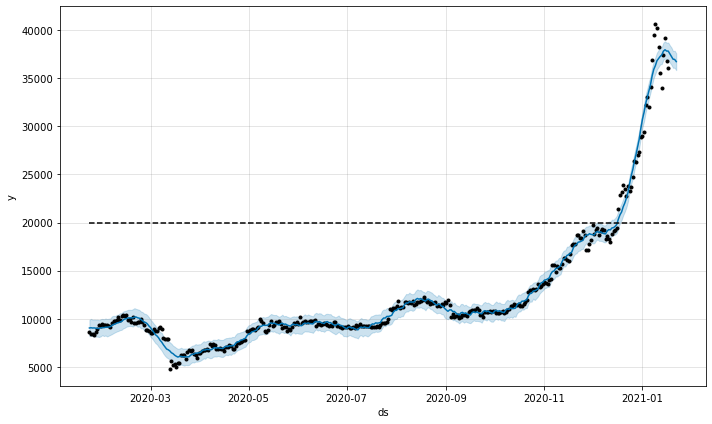

In [31]:
# 5일을 내다보며 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가 설정
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

- 겉으로 보기에는 원래의 결과와 별 차이가 없어 보인다.

#### _실제 데이터와의 비교_

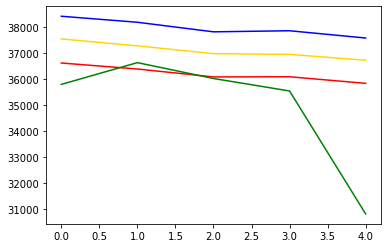

In [32]:
pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측
test_y = bitcoin_test_df.y.values # 실제 5일 가격
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 하한가 예측
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 상한가 예측

plt.plot(pred_y, color='gold') # 모델 예측값
plt.plot(pred_y_lower, color='red') # 모델 예측 하한가
plt.plot(pred_y_upper, color='blue') # 모델 예측 상한가
plt.plot(test_y, color='green') # 실제값

2882.000401361492


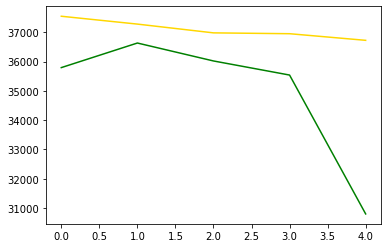

In [33]:
plt.plot(pred_y, color='gold') # 모델 예측값
plt.plot(test_y, color='green') # 실제값

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

- 상한가라는 개념이 큰 의미가 없는 비트코인 데이터의 경우에는 상한선을 설정함으로써 오히려 예측력이 다소 떨어지는 결과를 보임

### _(2) 이상치 제거 기법_

- 이상치 : 평균적인 수치에 비해 지나치게 높거나 낮은 수치의 데이터를 의미
- fbprophet 모델이 이상치를 제거한 데이터로 학습하려면 이상치에 해당하는 데이터를 None으로 설정해주면 된다.

In [34]:
bitcoin_df = pd.read_csv(file_path, names=['ds','y'])
bitcoin_df.drop(bitcoin_df.index[0], inplace=True)
bitcoin_df['y'] = bitcoin_df['y'].astype(float)
bitcoin_test_df = bitcoin_df[-5:] # test data
bitcoin_df = bitcoin_df[:-5] # train data

In [35]:
# 가격이 19000을 넘어가는 값을 이상치로 판단하여 None으로 설정
bitcoin_df.loc[bitcoin_df['y']>19000, 'y'] = None

In [36]:
prophet = Prophet(seasonality_mode='multiplicative',
                 yearly_seasonality=True,
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

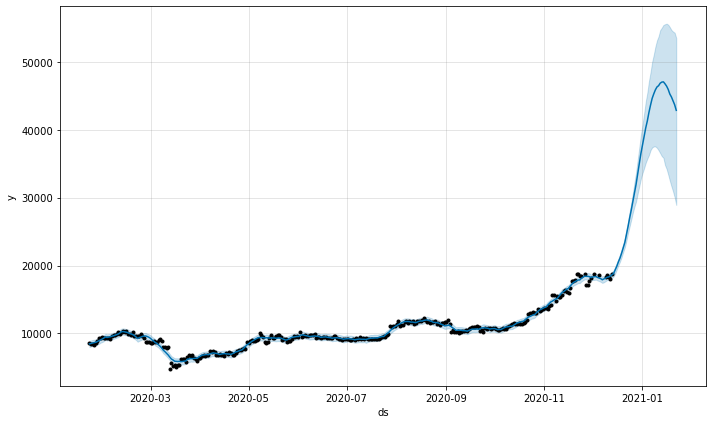

In [37]:
# 5일을 내다보며 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력
fig = prophet.plot(forecast_data)

#### _실제 데이터와의 비교_

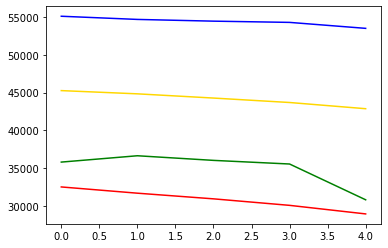

In [38]:
pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측
test_y = bitcoin_test_df.y.values # 실제 5일 가격
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 하한가 예측
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 상한가 예측

plt.plot(pred_y, color='gold') # 모델 예측값
plt.plot(pred_y_lower, color='red') # 모델 예측 하한가
plt.plot(pred_y_upper, color='blue') # 모델 예측 상한가
plt.plot(test_y, color='green') # 실제값

9350.58283748139


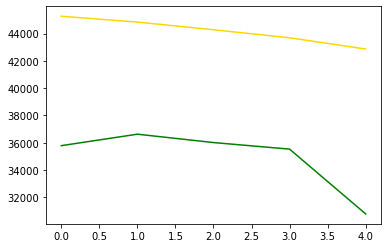

In [39]:
plt.plot(pred_y, color='gold') # 모델 예측값
plt.plot(test_y, color='green') # 실제값
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

=> 이상치를 제거하는 것이 정확도(RMSE)면에서나 '트렌트'를 예측하는 면에서나 이전 모델보다 안 좋다는 결론 도출

## 4) 참고 : ARIMA 모델의 하이퍼파라미터 선정

_* 적절한 파라미터 선정하기 *_  
- ARIMA 모델은 p, d, q 세 가지 파라미터를 적절하게 선정하는 것이 가장 중요
- ACF(Autocorrelation function), PACF(Partial atuocorrelation function) 그래프를 통해 대략적인 파라미터 선정

In [40]:
bitcoin_df = pd.read_csv(file_path, names=['day','price'])
bitcoin_df.drop(bitcoin_df.index[0], inplace=True)
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])
bitcoin_df.set_index('day', inplace=True)
bitcoin_df['price'] = bitcoin_df['price'].astype(float)
bitcoin_test_df = bitcoin_df[-5:] # test data
bitcoin_df = bitcoin_df[:-5] # train data
bitcoin_df.head()

,price
day,
2020-01-23,8658.94
2020-01-24,8388.11
2020-01-25,8428.17
2020-01-26,8327.36
2020-01-27,8588.42


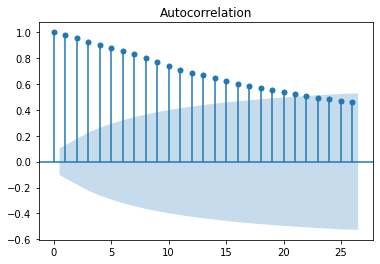

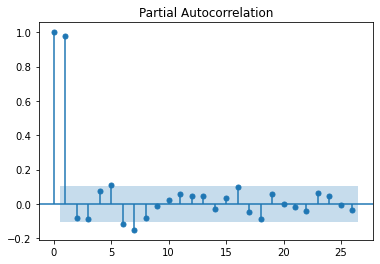

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bitcoin_df.price.values)
plot_pacf(bitcoin_df.price.values)
plt.show()

- ACF 결과 : 자기상관은 항상 양의 값을 가진다. -> p의 값은 크게 조절할 필요가 없다고 판단
- PACF 결과 : 처음 시차를 제외하고 급격히 감소 -> 종합적으로 고려하면 p=0, q=1로 파라미터를 조정하는 것이 적절하다고 판단

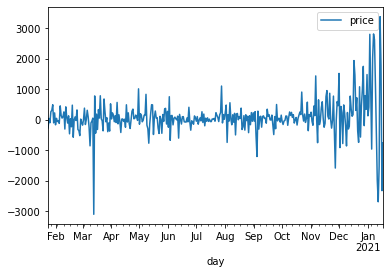

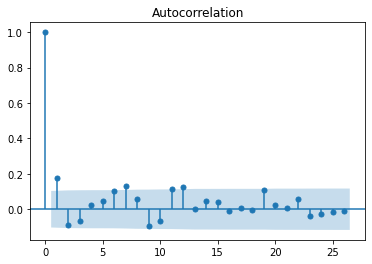

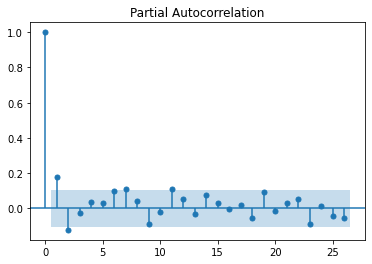

In [42]:
# 적절 차분 차수 d 계산 
tmp=bitcoin_df.diff(periods=1).iloc[1:]
tmp.plot()
plot_acf(tmp)
plot_pacf(tmp)
plt.show()

- 차분이란 현재 상태의 변수에서 바로 전 상태의 변수를 빼주는 것을 의미하며, 시계열 데이터의 불규칙성을 조금이나마 보정해주는 역할을 수행한다. 또한 ARIMA의 경향성을 반영한 값이다. 
- 위 결과를 바탕으로 최종 파라미터는 (0,1,1)로 결정  

(참고) https://jihyun22.github.io/%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D/time-series-01/